In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , TensorDataset
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
import torch.nn.init as init
import cudnn

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm

import copy
import seaborn as sns

from scipy.stats import norm
from sklearn.neighbors import KernelDensity, LocalOutlierFactor

import tqdm

In [4]:
# model hyperparameters
cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if cuda else "cpu")

num_seeds = 30
training_seed = 21
seed = 0

all_state_dim = 64
all_action_dim = 19
state_dim = 64

# Load fullstate
data_fullstate = np.empty(num_seeds, dtype=object)
data_no_joint_pos = np.empty(num_seeds, dtype=object)
data_no_joint_vel = np.empty(num_seeds, dtype=object)
data_no_action = np.empty(num_seeds, dtype=object)
data_no_imu = np.empty(num_seeds, dtype=object)
data_no_fc = np.empty(num_seeds, dtype=object)
for i in range(num_seeds):
    data_fullstate[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-fullstate-rand-{i}.npz")    
    data_no_joint_pos[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-no_joint_pos-rand-{i}.npz")
    data_no_joint_vel[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-no_joint_vel-rand-{i}.npz")
    data_no_action[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-no_action-rand-{i}.npz")
    data_no_imu[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-no_imu-rand-{i}.npz")
    data_no_fc[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-no_fc-rand-{i}.npz")
    

train_x = torch.empty((0, all_state_dim), dtype=torch.float32 ,device=DEVICE)
train_y = torch.empty((0, all_action_dim), dtype=torch.float32,device=DEVICE)
test_x = torch.empty((0, all_state_dim), dtype=torch.float32,device=DEVICE)
test_y = torch.empty((0, all_action_dim), dtype=torch.float32,device=DEVICE)
for i in range(training_seed):
    train_x = torch.cat((train_x, torch.tensor(data_fullstate[i]["state"].reshape(data_fullstate[i]["state"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)
    train_y = torch.cat((train_y, torch.tensor(data_fullstate[i]["action_lowpass"].reshape(data_fullstate[i]["action_lowpass"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)
for j in range(training_seed, num_seeds):
    test_x = torch.cat((test_x, torch.tensor(data_no_joint_pos[j]["state"].reshape(data_no_joint_pos[j]["state"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)
    test_y = torch.cat((test_y, torch.tensor(data_no_joint_pos[j]["action_lowpass"].reshape(data_no_joint_pos[j]["action_lowpass"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)

In [11]:
def plot_joint_values(data, state_index, batch_size=1000):
    """
    Plot joint values for specific state indices in 2-column subplots.

    Parameters:
    data (torch.Tensor): Shape (N, num_states)
    state_index (list or array): Indices of states to plot
    batch_size (int): Number of time steps to plot
    """
    num_states = len(state_index)
    num_cols = 3
    num_rows = int(np.ceil(num_states / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 2.5))
    axes = axes.flatten()

    for idx, state in enumerate(state_index):
        axes[idx].plot(data[:batch_size, state].cpu().numpy(), label=f'Joint state {state}')
        axes[idx].set_xlabel('Time step')
        axes[idx].set_ylabel('Joint value')
        axes[idx].legend()

    # ลบ axes ที่ไม่ได้ใช้
    for j in range(num_states, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [15]:
def plot_compare_joint_values(data_x, data_y, state_index, batch_size=1000):
    """
    Plot joint values for specific state indices in 2-column subplots.

    Parameters:
    data (torch.Tensor): Shape (N, num_states)
    state_index (list or array): Indices of states to plot
    batch_size (int): Number of time steps to plot
    """
    num_states = len(state_index)
    num_cols = 3
    num_rows = int(np.ceil(num_states / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 2.5))
    axes = axes.flatten()

    for idx, state in enumerate(state_index):
        axes[idx].plot(data_x[:batch_size, state].cpu().numpy(), label=f'Joint state {state}')
        axes[idx].plot(data_y[:batch_size, state].cpu().numpy(), label=f'action Joint state {state}')
        axes[idx].set_xlabel('Time step')
        axes[idx].set_ylabel('Joint value')
        axes[idx].legend()

    # ลบ axes ที่ไม่ได้ใช้
    for j in range(num_states, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

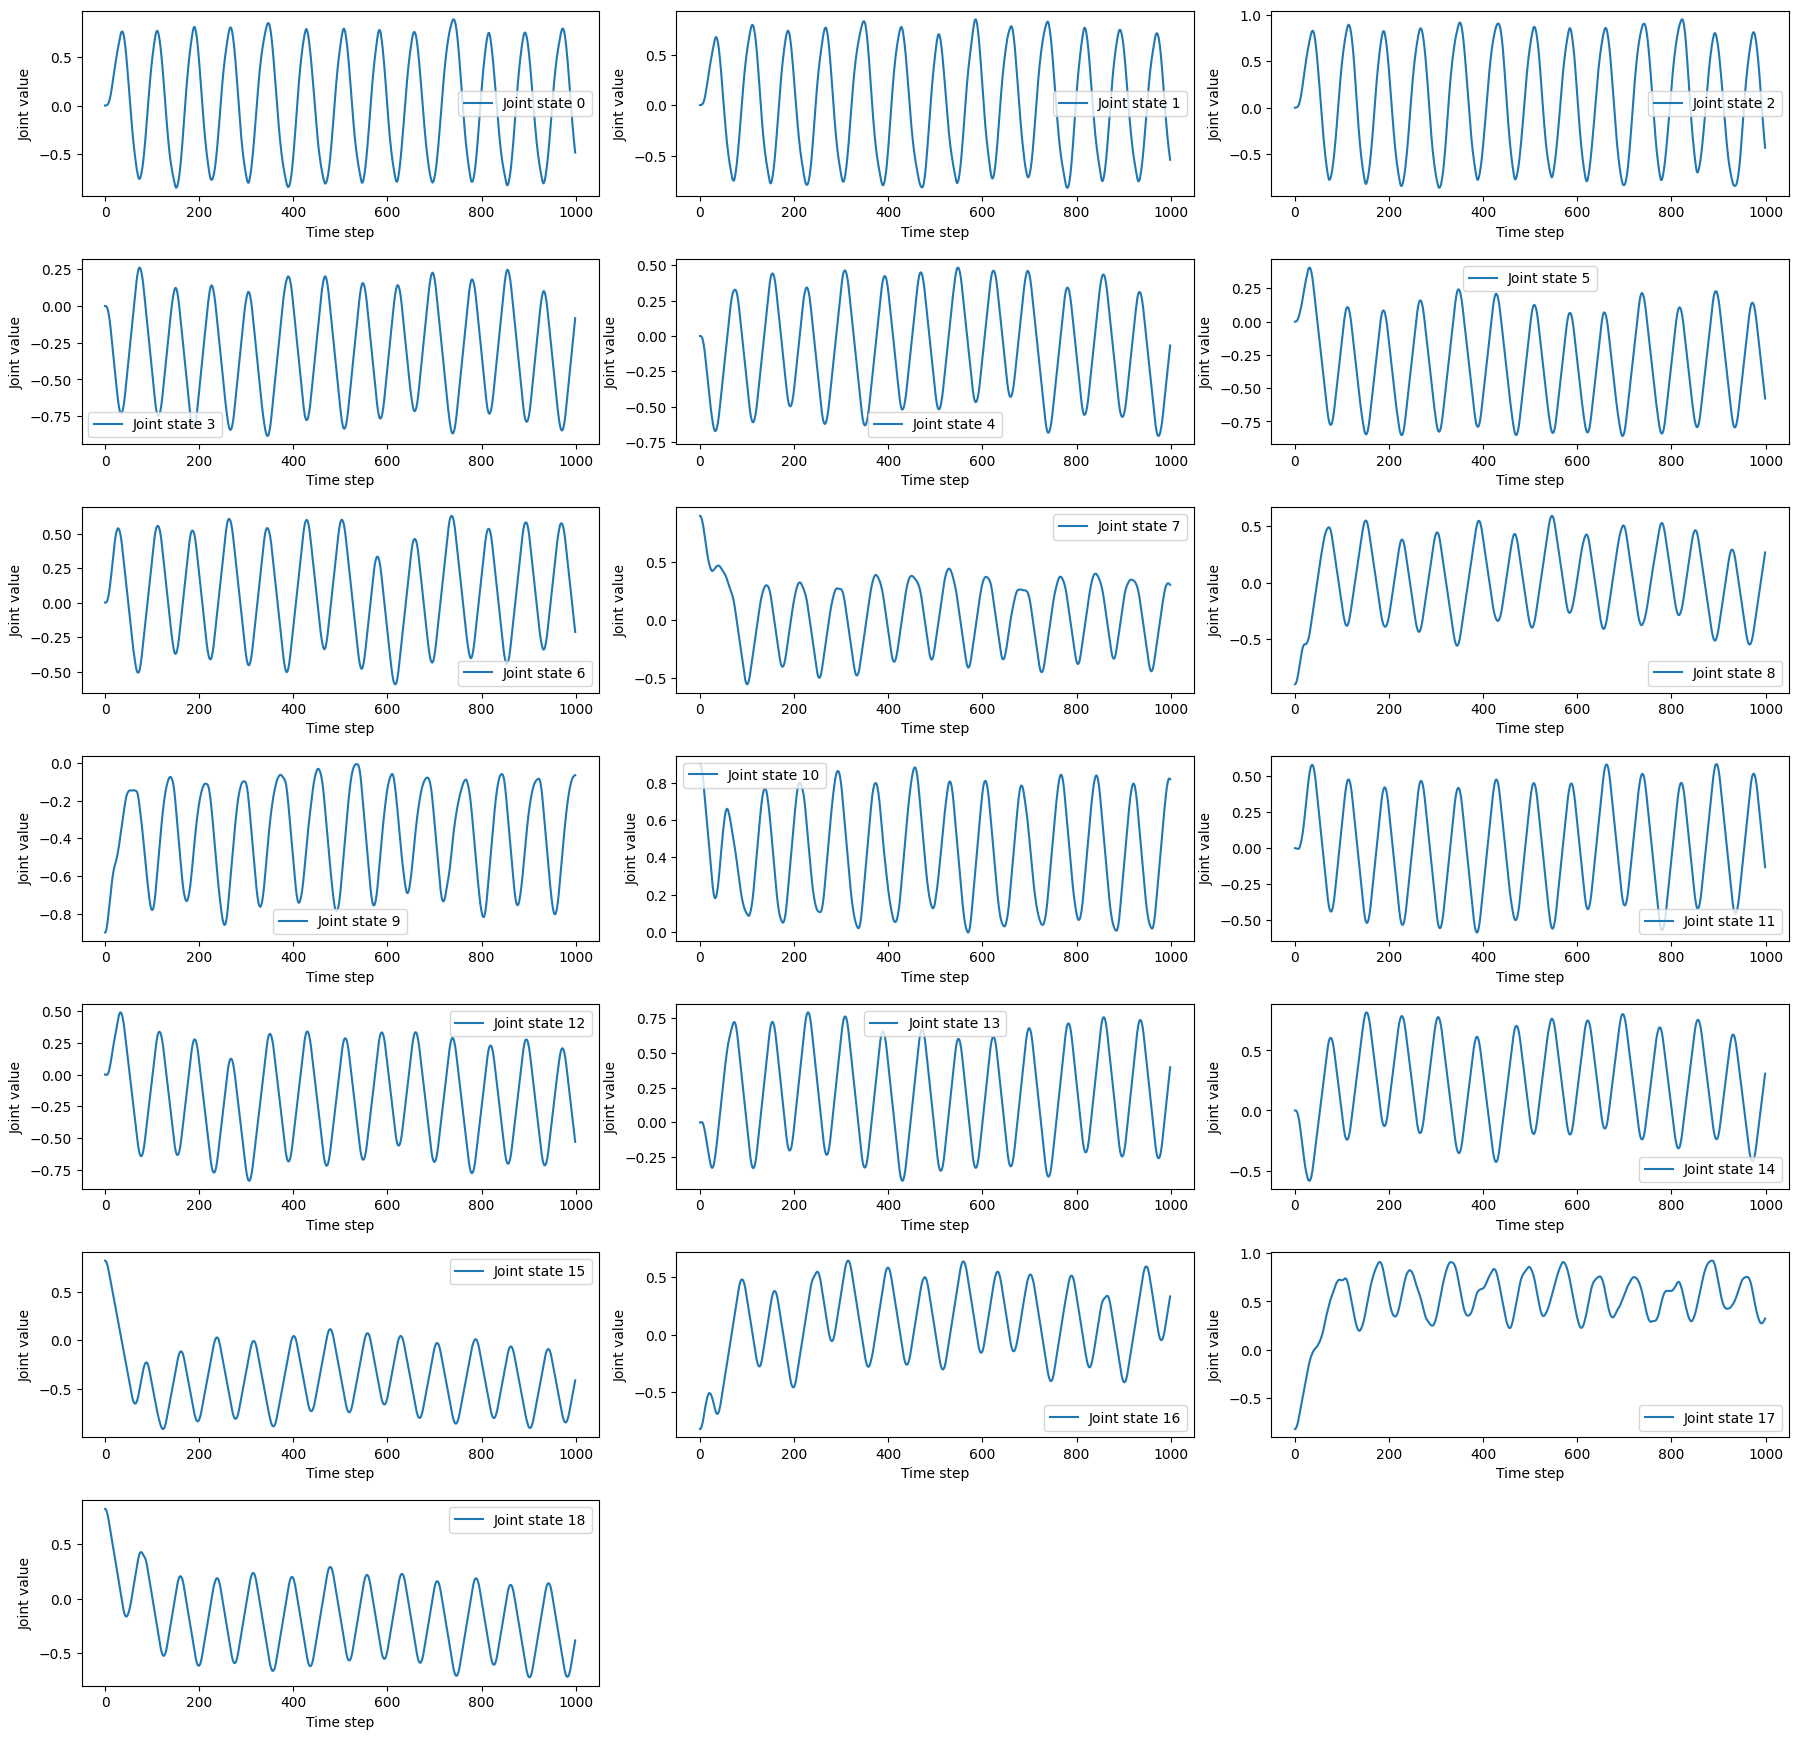

In [ ]:
plot_joint_values(train_x, state_index=torch.arange(0, 19), batch_size=1000)

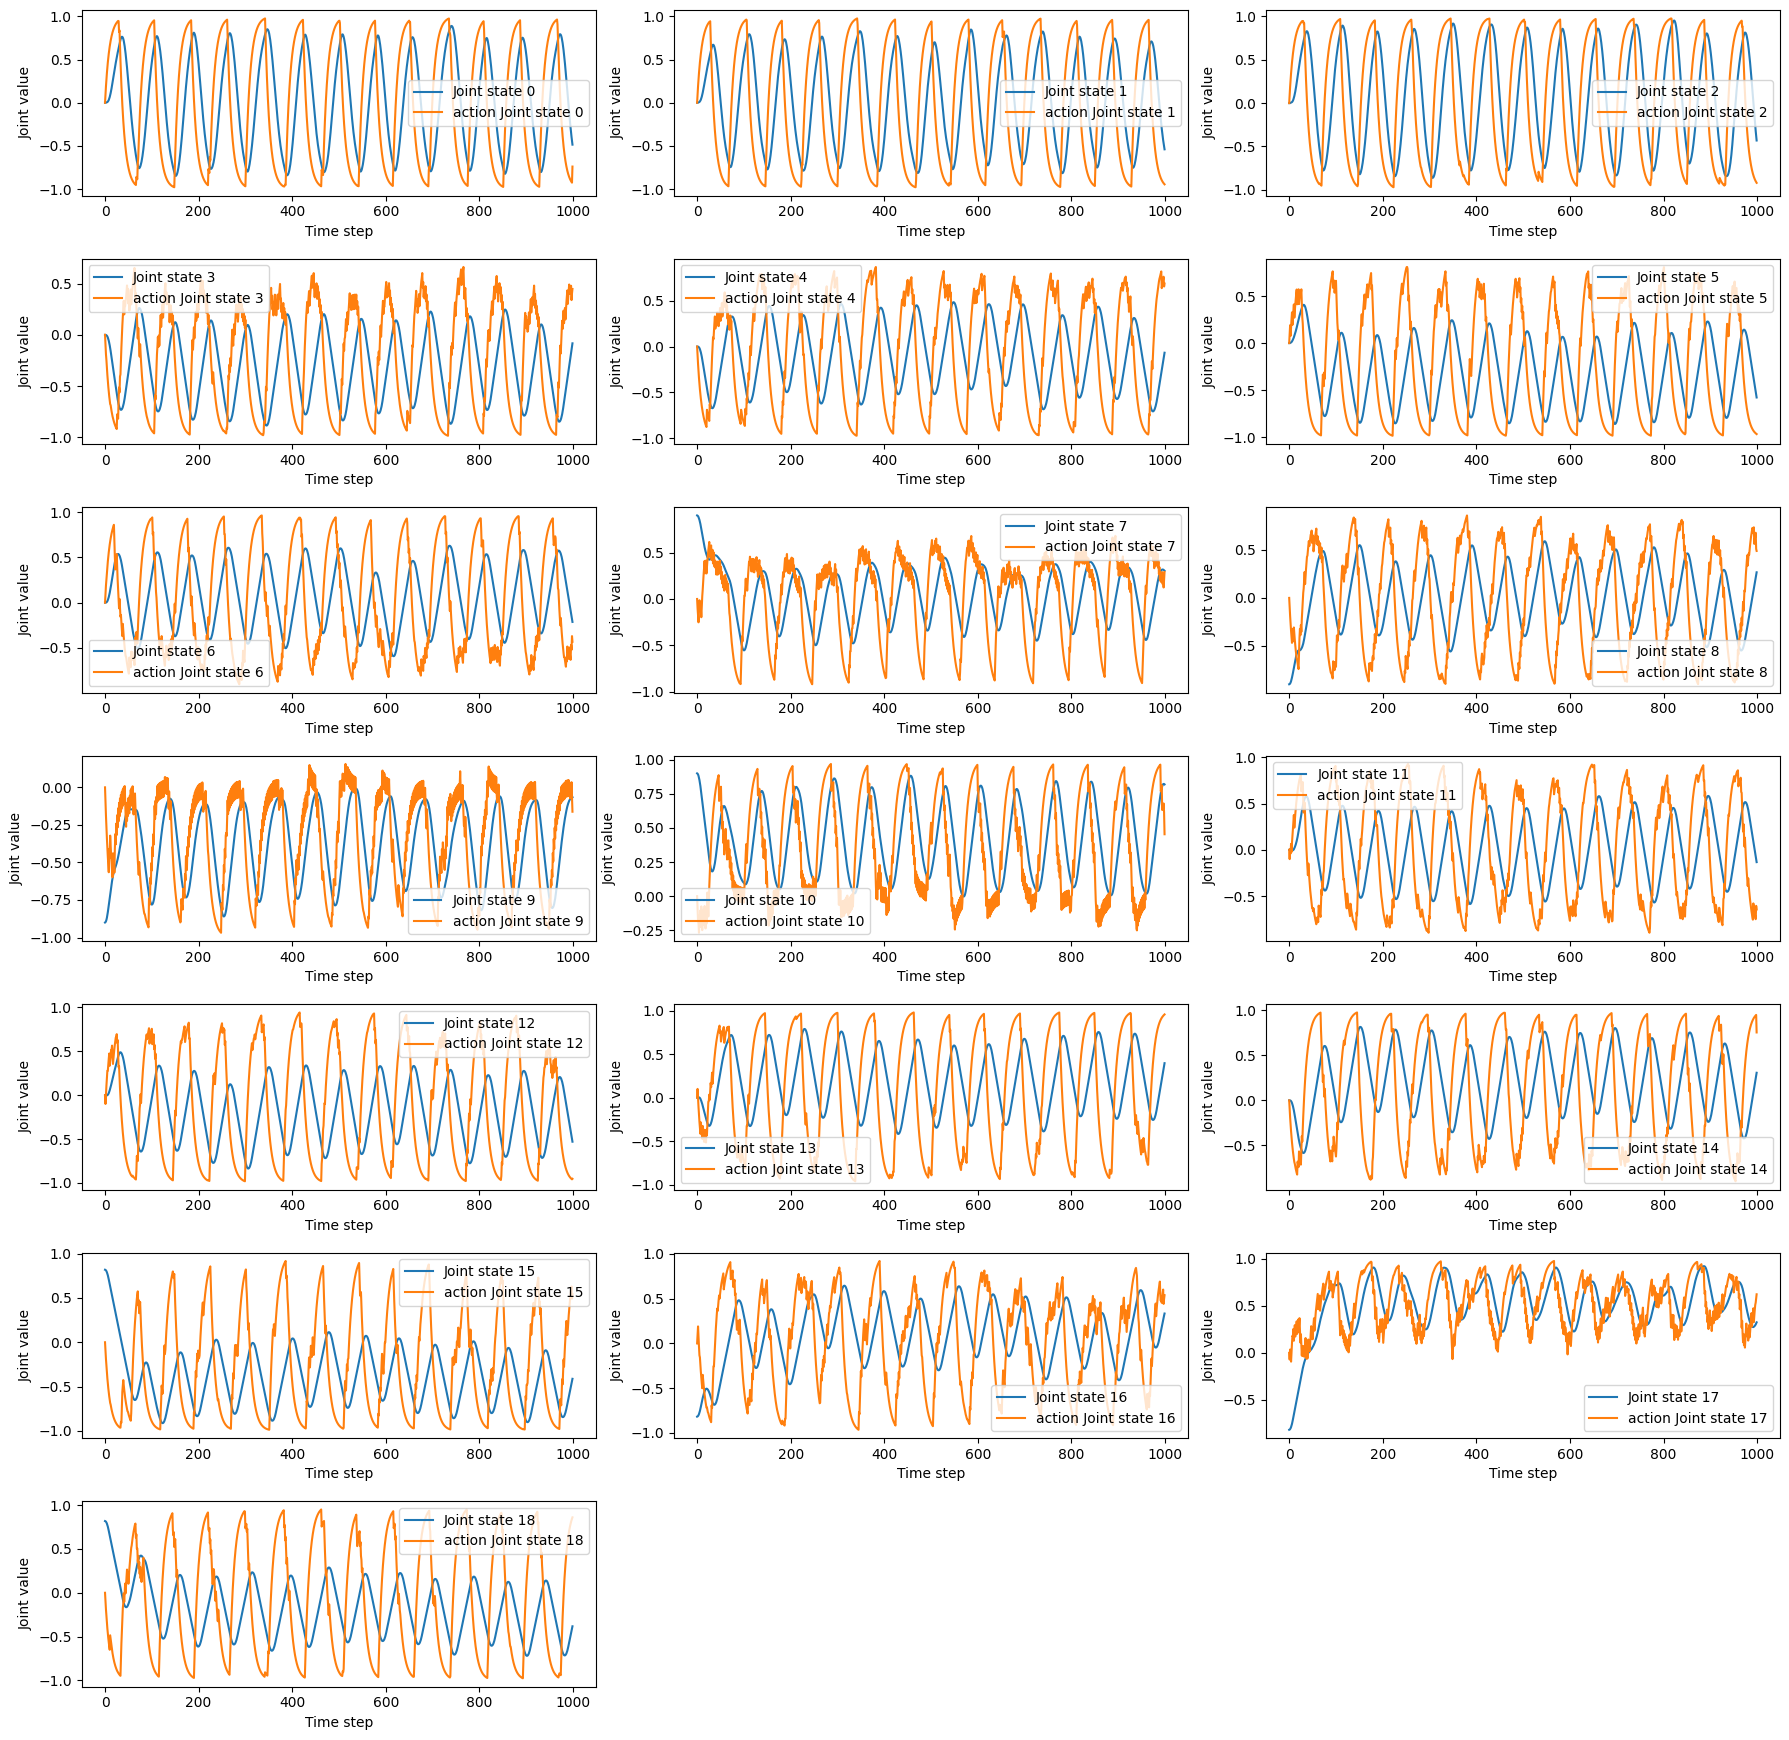

In [17]:
plot_compare_joint_values(train_x, train_y, state_index=torch.arange(0, 19), batch_size=1000)